# Learning Rate Finder
### By Noah Ziems

Learning rates can be really hard to fine tune sometimes. If you're experimenting with new things, the last thing you want to do is worry whether your learning rate(lr for short) is wrong or not.

To solve this problem, you can use a learning rate finding algorithm that tries out a bunch of different learning rates to see which seem to work best. These lr finding algorithms are purely emperical so by no means do they guarantee the ideal learning rate, but they seem to work pretty well in practice.

For more, [here is a blog by Sylvain Gugger](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

### Imports

First we need to import everything we'll need

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import math
import matplotlib.pyplot as plt

### Data

Now let's setup our train and test dataset along with their respective dataloaders. I wont go into those here, as they aren't the focus of this notebook.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### Nerual Network

Let's create a really basic convolutional neural network. Keep in mind that the learning rate finding algorithm should work with any architecture. I define the network then go ahead and create an instance of it and pop it on the GPU so I don't have to wait as long.

[I stole this model from the PyTorch examples](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.cuda()

### Loss Function and Optimizer

The learning rate finder requires a loss function, optimizer, and a model to be already defined. Lets use Cross Entropy and Adam. Keep in mind that the learning rate finder is designed to work regardless of which loss function and optimizer you are using, just like the model above.

It's also worth noting that you do not need to set a learning rate for the optimizer here because it gets overwritten by the learning rate finder.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Learning Rate Finder

Finally, after all that setup, we can get down to business. There is a lot of code here, but the idea is very simple. We start with a small learning rate, in this case `1e-7` and exponentially work our way up to a very large learning rate, in this case `10`, keeping track of the learning rates and losses along the way. Keep in mind that we are not linearly increasing the learning rate, as that would cause a higher concentrations of samples at larger lrs and lower concentrations at the smaller lrs.

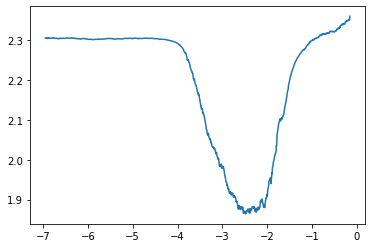

In [5]:
def find_lr(init_value=1e-7, final_value=10., beta = 0.98):
    num = len(trainloader)-1
    mult = (final_value / init_value)**(1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr 
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for i, data in enumerate(trainloader):
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        # Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        # Do the SGD step
        loss.backward()
        optimizer.step()
        # Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

log_lrs, losses = find_lr()
plt.plot(log_lrs[10:-5], losses[10:-5])
plt.show()

### Reading the Graph

After we've plotted the learning rates(technically their logs) and their respective losses, its clear to see which learning rates have the best losses. However, emperically, a good learning rate is usually found in the middle of the steepest negative slope.

In this case, it looks like the slope is negative between `-4` and `-2`, which means a good learning rate would be ~`1e-3`. Lets try it out for an epoch and see how it does!

We need to reset the optimizer and network because they were changed in the process of finding the learning rate. After that we just train the model for an epoch. Note we set `lr=1e-3`.

In [7]:
net = Net()
net = net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

def train(nb_epoch=1):
    for epoch in range(nb_epoch):
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    print('Finished Training')
    
train(1)

Finished Training


How did we do after just one epoch? Keep in mind that baseline accuracy for CIFAR-10, the dataset we're using, is around 10%.

In [9]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
test()

Accuracy of the network on the 10000 test images: 49 %


Look at that! Our accuracy is way better than 10%! We've nailed it! Looks like the lr finding algorithm works and we read the graph correctly.

Let's run it for a few more epochs to see how much better we can get it.

In [10]:
train(10)
test()

Finished Training
Accuracy of the network on the 10000 test images: 64 %


Looks great! Thanks for reading :D